In [ ]:
import math
import random
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df= pd.read_csv('/content/drive/MyDrive/Datasets/IBM.csv')

In [ ]:
# convert date to datetime format  (D/M/Y)                   #  NOTE: Running this cell more than once will generate an error !!!
df['Date'] = pd.to_datetime(df['Date'])

In [ ]:
# Define the date range
start_date = '2008-01-01'
end_date = '2020-04-01'

# Slice the DataFrame based on the date range
sliced_df = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]

sliced_df

,Date,Open,High,Low,Close,Adj Close,Volume
11579,2008-01-02,108.989998,108.989998,104.169998,104.690002,73.110321,9503500
11580,2008-01-03,104.830002,105.570000,103.980003,104.900002,73.256996,7528900
11581,2008-01-04,103.949997,103.949997,100.480003,101.129997,70.624199,11034600
11582,2008-01-07,100.250000,101.000000,99.029999,100.050003,69.870010,12650400
11583,2008-01-08,100.050003,100.379997,97.169998,97.589996,68.152061,9434400
...,...,...,...,...,...,...,...
14658,2020-03-26,106.910004,113.150002,105.570000,112.889999,112.889999,7153500
14659,2020-03-27,108.580002,111.500000,107.650002,108.029999,108.029999,6423000
14660,2020-03-30,108.089996,113.459999,107.809998,112.930000,112.930000,5564500
14661,2020-03-31,112.000000,113.809998,110.169998,110.930000,110.930000,6343300


In [ ]:
# Resetting the index from 0 to .... no of samples
new_df = sliced_df.reset_index()['Close']

new_df[0:5]

,Close
0,104.690002
1,104.900002
2,101.129997
3,100.050003
4,97.589996


In [ ]:
train_size = int(len(new_df) * 0.8)
train, test = new_df[:train_size], new_df[train_size:]

<font color="yellow"> <b> <h3> Stationary check by ADF test </font> </br>

[stationary check in details](https://www.analyticsvidhya.com/blog/2021/06/statistical-tests-to-check-stationarity-in-time-series-part-1/)  </br>

[mathematics behind stationary check](https://medium.com/@ritusantra/tests-for-stationarity-in-time-series-dickey-fuller-test-augmented-dickey-fuller-adf-test-d2e92e214360)

In [ ]:
from statsmodels.tsa.stattools import adfuller

# >>> If the ADF statistic is significantly negative and the p-value is low (typically below 0.05), it suggests that the series is stationary.
# >> Adf statistic less than critical values indicated stationary

result = adfuller(train)
print(f'ADF Statistic: {result[0]}')  #  more negative value of the ADF statistic implies a stronger rejection of the null hypothesis
print(f'p-value: {result[1]}')        #  A p-value below a certain threshold (commonly 0.05) indicates that the null hypothesis can be rejected
print('Critical Values:')
for key, value in result[4].items():
    print(f'\t{key}: {value:.3f}')


ADF Statistic: -1.9112089614973027
p-value: 0.3268065736786119
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


In [ ]:
# If p-value > 0.05, data is non-stationary, we differentiate to make it stationary
differenced = train.diff().dropna()

In [ ]:
# Check again to make sure it is stationary

result = adfuller(differenced)
print(f'ADF Statistic (Differenced): {result[0]}')
print(f'p-value (Differenced): {result[1]}')
print('Critical Values:')
for key, value in result[4].items():
    print(f'\t{key}: {value:.3f}')

ADF Statistic (Differenced): -49.57897439193879
p-value (Differenced): 0.0
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


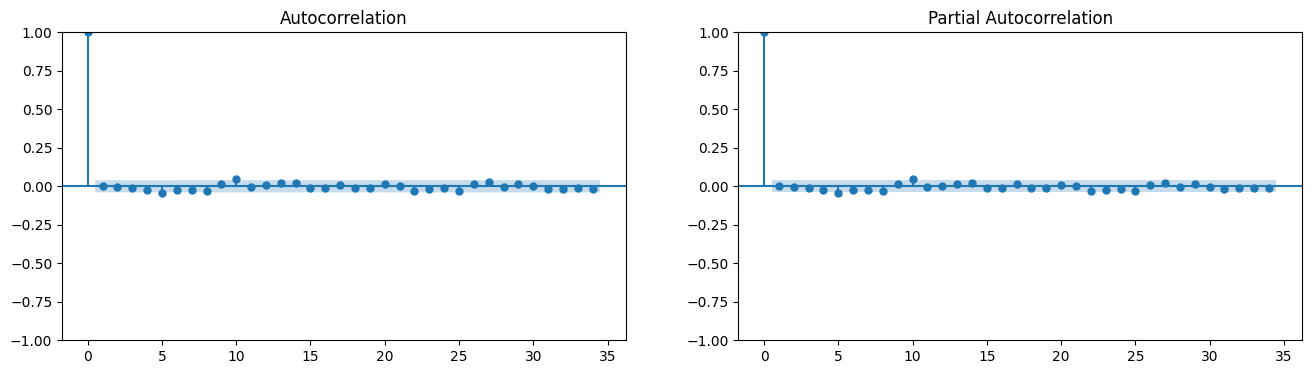

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plotting ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
plot_acf(differenced, ax=axes[0])
plot_pacf(differenced, ax=axes[1])
plt.show()


[How to find p value](https://www.youtube.com/watch?v=_nSvoCkodS8) </br>
[How to find q values](https://www.youtube.com/watch?v=a0BVTH86JrI)

<font color="yellow"> <b> <h3> ARIMA model

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

p = 2  # Example value, determine from PACF
d = 1  # Differencing once
q = 2  # Example value, determine from ACF

# Building the ARIMA model
model = ARIMA(train, order=(p, d, q))
model_fit = model.fit()
print(model_fit.summary())


In [ ]:
# Make predictions on the test data
history = list(train)  # Converting training data to a list for updating
predictions = []

for t in range(len(test)):                    # We need to generate a prediction for each point in the test set
    model = ARIMA(history, order=(p, d, q))   # ARIMA model is being re-fitted at each time step
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]      # Makes a one-step-ahead forecast;  [0] extracts the first value (since forecast() returns an array
    predictions.append(yhat)
    history.append(test.iloc[t])  # Update the history with the actual observation


<font color= "aqua"> <b> series = [1,2,3,4,5,6,7,8,9,10] <br>
train = [1,2,3,4,5,6,7]  &nbsp; test =[8,9,10] <br>
t=0 so, test[0] = 8, &nbsp; history=[1,2,3,4,5,6,7],&nbsp; prediction= [6] <br>
t=1 so, test[1]= 9, &nbsp; history= [1,2,3,4,5,6,7,8], &nbsp; prediction= [6,8] <br>
t=2 so, test[2]= 10, &nbsp; history= [1,2,3,4,5,6,7,8,9], &nbsp; prediction= [6,8,8] <br>

In [ ]:
predictions

[146.5904644935375,
 159.47856037855138,
 160.71603345322015,
 162.06788250323928,
 159.5391497872318,
 155.70629888046616,
 153.42546879700106,
 153.62249188026024,
 153.81655896955948,
 154.45555458474445,
 154.2932327330897,
 154.25054609527476,
 153.5224547165867,
 151.69221257074477,
 150.83225325634916,
 151.26954343300628,
 151.70499453153033,
 150.12066913438034,
 149.21348826819263,
 148.27164111547083,
 148.82845135646,
 147.1234400569007,
 149.23387867169245,
 149.13413571328311,
 150.3222221602063,
 152.10228898280937,
 151.8611155306097,
 151.85041789087768,
 151.9124229448375,
 152.33245371063384,
 153.50354799486155,
 153.77228992360327,
 154.76195809915544,
 156.4648968513823,
 155.28377819606783,
 154.23834742283168,
 153.68667071507215,
 154.95242337403005,
 155.6069210652042,
 156.91717335126128,
 154.0360530225977,
 154.06132181472915,
 152.49343925283208,
 153.33844761410336,
 153.22676713722072,
 152.94923777200486,
 151.49507947610982,
 152.4007053339325,
 152.77

In [ ]:
from sklearn.metrics import mean_squared_error

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test, predictions))
print(f'RMSE: {rmse}')

RMSE: 2.404345170834038


In [ ]:
from sklearn.metrics import mean_absolute_percentage_error

# Calculate test data MAPE
print("MAPE: ",mean_absolute_percentage_error(test,predictions))

MAPE:  0.011491944327097334


In [ ]:
from sklearn.metrics import r2_score

# Calculate test data R2
print("R2 score: ", r2_score(test,predictions))

R2 score:  0.9623876146629499


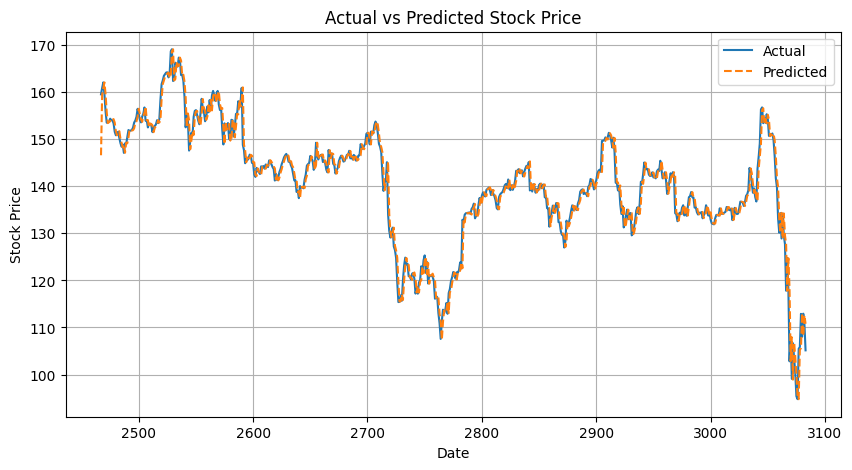

In [ ]:
# Optionally, plot the actual vs predicted values
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, predictions, label='Predicted', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Actual vs Predicted Stock Price')
plt.legend()
plt.grid(True)
plt.show()